# [E-07] Portrait Mode
"Exploration Node 7. Let's make Portrait" / 2022. 02. 03 (Thu) 이형주

## Contents
---
- **1. 최초 이미지 준비 및 모델링 투입**
- **2. 아웃 포커싱 - Portrait Mode**
- **3. (응용) 고양이 사진**
- **4. (응용) 사진 합성하기 - Chromakey**
- **5. Portrait Mode 문제점 확인 및 솔루션 제시**
- **6. 프로젝트 회고**


## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. 인물모드 사진을 성공적으로 제작하였다.|아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
|2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

## 1. 최초 이미지 준비 및 모델링 투입

In [1]:
# 패키지, 모듈 로드

import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf

img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/my_image.jpeg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1440, 1080, 3)


In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    # tf.compat.v1.import_graph_def를 통해 그래프 구조를 불러옵니다.
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
        
        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')
        
        self.sess = tf.compat.v1.Session(graph=self.graph)
        
    # 이미지 전처리, Numpy Array로 변환
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]  # color channel을 제외한다.
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB) 
    # bgr -> rgb 변환
        img_input = resized_rgb
        return img_input
    
    def run(self, image):
        img_input = self.preprocess(image)  # 전처리 함수를 통해 이미지 전처리, 입력값
        
    # Tensorflow V1 의 모델 작동 : sess.run()
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})
        
        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map
    
_MODEL_URL_ = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print('temporary dir. :', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):  # path 오류 발생시, url에서 진행
    urllib.request.urlretrieve(_MODEL_URL_ + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                             download_path)
    
MODEL = DeepLabModel(download_path)
print('모델 잘 불러왔어요~')

temporary dir. : /aiffel/aiffel/human_segmentation/models
모델 잘 불러왔어요~


In [4]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(1440, 1080, 3) (513, 384, 3) 15


21

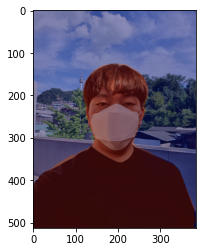

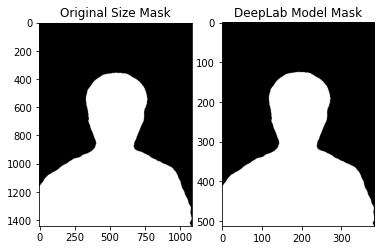

In [6]:
# 각 라벨별 이름. 0부터 시작하여 seg_map에 적용.
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) 
# person == 15
img_mask = seg_map * (255/seg_map.max()) 
# 정규화
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) 
# thresh=128, 임계값보다 크면 255 적용
# 블러의 확실한 경계를 설정하기 위해 임계값 처리.
ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 2. 아웃 포커싱 (Portrait Mode)

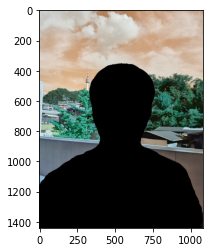

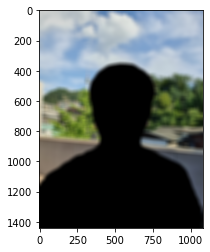

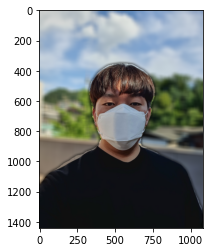

In [7]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR) 
# 흑백처리되었던 이미지를 다시 BGR로
img_bg_mask = cv2.bitwise_not(img_mask_color) 
# 이미지 반전
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) 
# 이미지 비트 and 연산
plt.imshow(img_bg)
plt.show()

img_bg_blur = cv2.blur(img_bg, (33, 33)) 
#커널로 convolution 연산. 사이즈가 클 수록 블러가 강하게 적용
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 3. (응용) 고양이 사진

(191, 264, 3)
(191, 264, 3) (371, 513, 3) 8


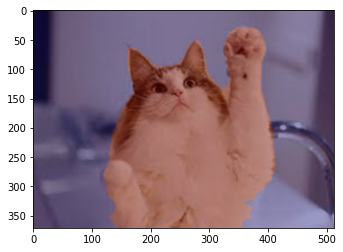

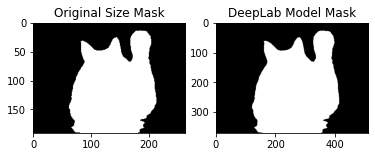

In [9]:
import os
img_path = os.getenv('HOME')+ '/aiffel/human_segmentation/images/nyangpunch.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) 
# cat == 8
img_mask = seg_map * (255/seg_map.max()) 
# 정규화
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) 
# thresh=128, 임계값보다 크면 255 적용
# 블러의 확실한 경계를 설정하기 위해 임계값 처리
ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

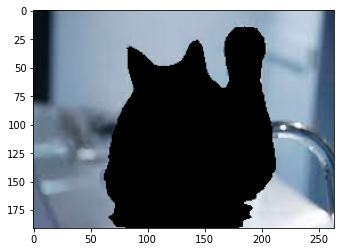

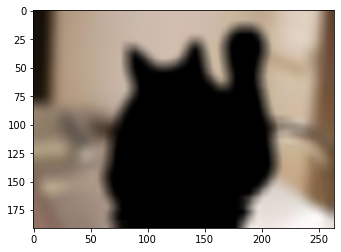

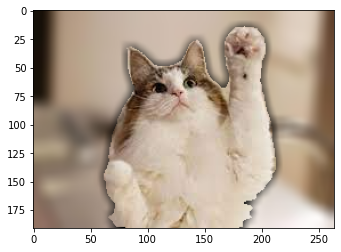

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR) 
# 흑백처리되었던 이미지를 다시 BGR로
img_bg_mask = cv2.bitwise_not(img_mask_color)
# 이미지 반전
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) 
# 이미지 비트 and 연산
plt.imshow(img_bg)
plt.show()

img_bg_blur = cv2.blur(img_bg, (13,13))  
# 커널 convolution 연산
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 4. (응용) 사진 합성하기 - Chromakey

(333, 600, 3)
(191, 264, 3)


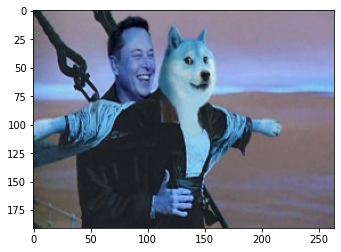

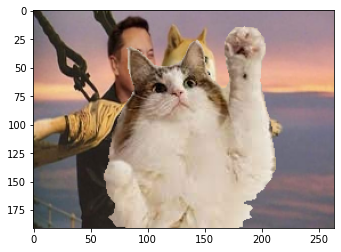

In [12]:
img_path = os.getenv('HOME')+ '/aiffel/human_segmentation/images/gotomars.jpg'
img_gotomars = cv2.imread(img_path) 
print(img_gotomars.shape)

target_size = img_orig.shape[:2][::-1]
resized_gotomars = cv2.resize(img_gotomars, target_size)
print(resized_gotomars.shape)

plt.imshow(resized_gotomars)
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, resized_gotomars)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 5. Portrait Mode 문제점 확인 및 솔루션 제시

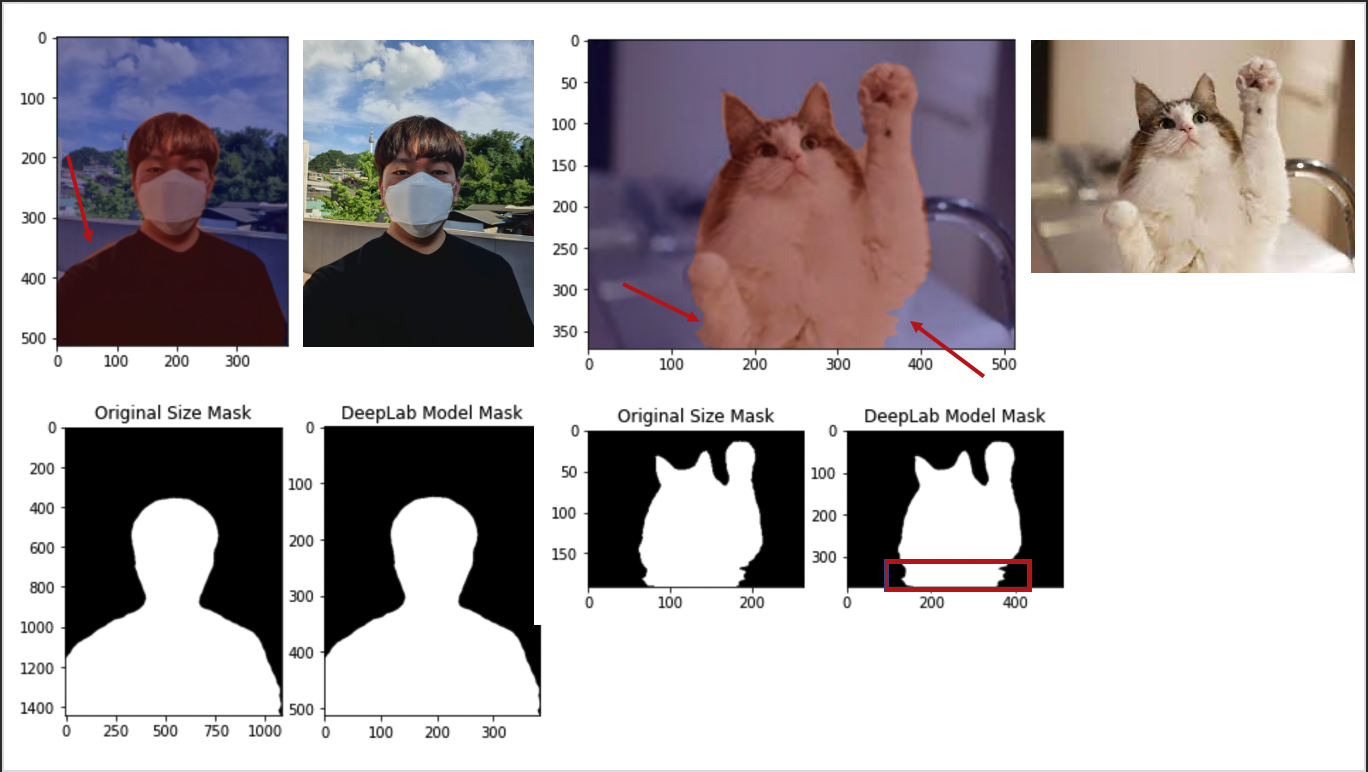

+ 전반적으로 DeepLab의 Segmentation이 조금 아쉬웠다.
    - 본인 사진에서는 콘트리트 벽과 검정색 옷 사이의 경계를 모호하게 인식하였고
    - 고양이 사진에서는 털과 인테리어 사이를 잘 구분해내지 못했다. 물론 이 사진의 해상도가 낮았다는 점을 감안해도 말이다.
+ 그 이유를 명확히 파악하기 위하여 DeepLab의 초기 버전부터 V3+까지의 논문을 참고하였다.
    - 논문1. DeepLab V1 : https://arxiv.org/pdf/1412.7062.pdf
    - 논문2. DeepLab V2 : https://arxiv.org/pdf/1606.00915.pdf
    - 논문3. DeepLab V3 : https://arxiv.org/pdf/1706.05587.pdf
    - 논문4. DeepLab V3+ : https://arxiv.org/pdf/1802.02611.pdf

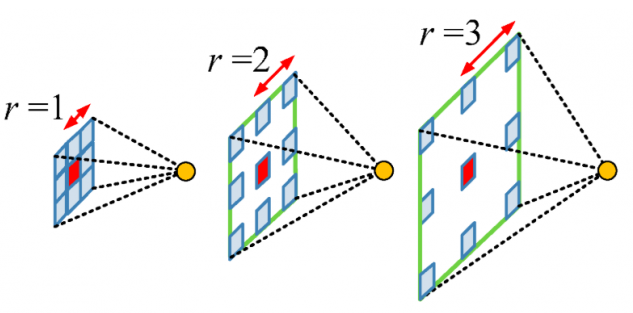

- 참고 블로그의 설명으로 단점의 가닥을 잡을 수 있었다: https://kuklife.tistory.com/121
    + Atrous Convolution: Atrous Convolution을 활용함으로써 얻을 수 있는 이점은 기존 convolution과 동일한 양의 파라미터와 계산량을 유지하면서도, **field of view(한 픽셀이 볼 수 있는 영역)를 크게 가져갈 수 있게 된다는 것이다.** (중략) 보통 Semantic Segmentation에서 높은 성능을 내기 위해서는 CNN의 **마지막에 존재하는 한 픽셀이 입력값에서 어느 크기의 영역에서 커버할 수 있는지를 결정하는 receptive field 크기가 중요하게 작용한다.**
    + 즉, 여러 convolution과 pooling 과정에서 디테일한 정보가 줄어들고 특성이 점점 추상화되는 것을 어느정도 방지할 수 있기 때문에 DeepLab series에서는 이를 적극적으로 활용하려 노력한다.
- DeepLab 모델은 픽셀 하나 하나의 레이블을 예측하는 것이므로 그 영역값이 커진다면 경계선처럼 세밀한 값을 잡아내지 못할 수 있다. 그래서 인물 또는 동물과 배경 사이의 경계 정확도가 떨어지는 것으로 추정된다.
- 따라서 이와 같은 경우에는 중요도를 구분하지 않고 모든 영역을 분석 및 예측할 수 있어야 한다.
    + **결론은 EfficientNet으로 대체하는 것이 바람직해 보인다.**
        * Source: https://lswook.tistory.com/106

## 6. 프로젝트 회고

+ Sticker 사진 Ex 프로젝트를 참고하여 이미지 벡터 연산 과정을 다시 한 번 복기하였으며 openCV에서 사용하는 다양한 함수들도 확인하는 계기가 되었다.
+ 경계선을 정확하게 잡아내지 못하는 문제 외에는 특이점이 없었던 건 다행이지만, 반대로 각 모델별 장단점을 구분하고 찾아내는데 많은 시간을 사용하였다.
+ 인물 여러명을 인식하고, 서로 구분할 수 있는 등의 조금 더 고도화된 작업을 해보고 싶다.